# PreMine
We know this is what was given out for premine but what should it have been?
2.5B / 5798 IoT ~ 431183 active hotspots

## Setup

In [1]:
!pip install --quiet duckdb
!pip install --quiet duckdb-engine
!pip install --quiet colab-env --upgrade

In [2]:
import os
import duckdb

db = duckdb.connect('premine.db')
db.execute("INSTALL httpfs")

In [3]:
from google.colab import drive
drive.mount('/gdrive')#, force_remount=True)
import colab_env

Mounted at /gdrive
Mounted at /content/gdrive


## Load 30days

The last 30 days of the og helium chain. presumably if hotspot is in this list it is active. This data came from hashc0de so ideally we'd find another source to duplicate. Screenshot from discord:
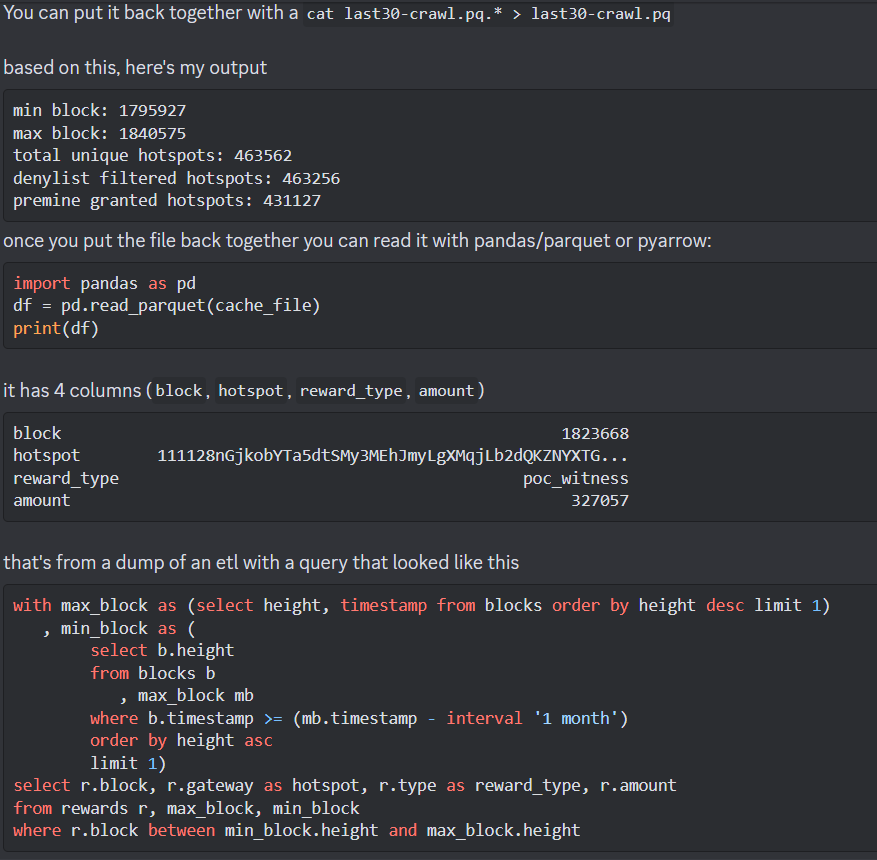

In [4]:
db.execute("CREATE OR REPLACE TABLE active AS \
    SELECT * FROM \
    read_parquet('/content/gdrive/My Drive/premine/last30-crawl.pq') \
    WHERE reward_type NOT IN ('consensus_rewards', 'securities_reward')")


hotspots = db.execute("SUMMARIZE SELECT * FROM active").df()
display(hotspots)



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,block,BIGINT,1795927,1840575,1442,1818051.7882070069,12993.447472703481,1806665,1818085,1829324,246732322,0.0%
1,hotspot,VARCHAR,111128nGjkobYTa5dtSMy3MEhJmyLgXMqjLb2dQKZNYXTG...,14sif7GEUCQbhW1RpTdEToEVFrv8v2RfLafckeFW3gS9ur...,454018,NaN,NaN,NaN,NaN,NaN,246732322,0.0%
2,reward_type,VARCHAR,dc_rewards,poc_witness,3,NaN,NaN,NaN,NaN,NaN,246732322,0.0%
3,amount,BIGINT,0,160045986,3249430,619009.0227971348,509484.7876478022,293810,424929,822562,246732322,0.0%


In [5]:
rewards = db.execute("COPY (SELECT DISTINCT hotspot from active) \
                      TO '/content/gdrive/My Drive/premine/hotspots_all.csv' (HEADER, DELIMITER ',')")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

https://drive.google.com/file/d/1-2KYrmcRPyPH5ipdO33JlYbp_ZoNKCnP/view


In [6]:
#ignore this cell. just the start of trying to see how many lone wolves. not complete

db.execute("CREATE OR REPLACE TABLE dc_only AS \
    SELECT DISTINCT(hotspot) FROM \
    read_parquet('/content/gdrive/My Drive/premine/last30-crawl.pq') \
    WHERE reward_type NOT IN ('consensus_rewards', 'securities_reward', 'poc_witness', 'poc_challengee')")


hotspots = db.execute("SELECT * FROM dc_only").df()
display(hotspots)



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,hotspot
0,112GiEEGjs6fhjhrjdsu1jTQtN5kymEJMJhFaeSNG5EL2i...
1,112Gevht3z732s6NRHqyjM3hjQcDnmYsHGif5xcVZJ4YX7...
2,112Gg9G5GJR8dRgab7Y2yfQaLUdaDfAy5Kxptob7nMmTzg...
3,112Gdy59BWXkuzzhSxqSpS4FfwZbaFiUh7Yp6RJ1UCTTeN...
4,112GpJem9CqT7p1RKNrBMojRKYMubS9ojvUvTB2gWEy7b8...
...,...
219919,11PGmTms55iEMqkz71ijLLtvczoPGHbReFnAP6jMG4ELWX...
219920,11PcteKV1ji29PkBToYyDGe2t2NJvbCQr4baNevLiaBsGJ...
219921,11QbvVuesK1HxM5ro4WrmJYqLjkrvpMTWaN5XnR3AZommZ...
219922,11QYqfWGkPB2d2BCNHkaQ2ikLkzsfbreP4EKFT6LPr9DCD...


## Load up denylist
from that time
~~https://github.com/helium/denylist/releases/tag/2023041401~~

Waveform says this is Apr 18:
https://raw.githubusercontent.com/helium/denylist/36706f3bc274424bd6c6457dfb7fb065e3ef7a64/denylist.csv

In [7]:
#db.execute("CREATE OR REPLACE TABLE denied AS \
#            SELECT * FROM read_csv('https://raw.githubusercontent.com/helium/denylist/36706f3bc274424bd6c6457dfb7fb065e3ef7a64/denylist.csv', \
#                                 columns={'hotspot': 'VARCHAR'})")

# download this manually to skip the line-feed trouble
db.execute("CREATE OR REPLACE TABLE denied AS \
            SELECT * FROM read_csv('/content/gdrive/My Drive/premine/denylist.csv', \
                                 columns={'hotspot': 'VARCHAR'})")


denied = db.execute("SELECT * FROM denied").df()
denied_hotspots = denied.values.tolist()
display(denied)

,hotspot
0,11114BBnvSd4Szo8UWPe2eJh2biAL2JCLpqvvtu2RdQaLs...
1,11115Ad71wv583yiPXZGCoaAYHECaE7gJrAUeDsozoXvJ7...
2,11125Ai9kBqVPDfjdgyvmXE4rJHXNXgodziNbW17nh87gP...
3,11126wzJryzJieSTgNfh3WAURxYGjMcvkooa8PqHuYgM3B...
4,11127oaWvjF4MJyqEg2oYHTkta77r7DagZw4WMTByve7yo...
...,...
157300,11zzk2QexMCeLjHXZezzLdJaZGr2u6FfaCxafihxtSbVX8...
157301,11zzmNL4F4ggqAkE5DiDJGmvE58Ho5yvcQeX2S2E3vy1M6...
157302,11zztk3EeMiwZ4hdgzKDpqwQJvc3Uq72N24wEHNnAzPUi7...
157303,11zzuDyGZ8yxiMf1p9BAmatZ2vr4374GndKdS4nvACRuiU...


In [8]:

distinct_hotspots = db.execute("SELECT DISTINCT hotspot FROM active").df().values.tolist()
display('length before', len(distinct_hotspots))

# Need to update the active table to remove the denied
hs_trim = db.execute("CREATE OR REPLACE TABLE active AS\
                 SELECT * FROM active \
                 WHERE hotspot NOT IN \
                (SELECT hotspot FROM denied \
                 )").df()

hs = db.execute("SELECT DISTINCT hotspot FROM active \
                 WHERE hotspot NOT IN \
                (SELECT hotspot FROM denied \
                 )").df()


hs_trim = db.execute("SELECT DISTINCT hotspot FROM active").df().values.tolist()

display('length after', len(hs_trim))
display(hs_trim[0:10])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

'length before'

463562

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

'length after'

463256

[['1123xsGN4enqdB6zf2CSoHsL5yiWDeBX1audDu2LsTW6tn8nUR6b'],
 ['1123xsYbivvWYMB5MTNHRgs7YaPitXePVUSezkSjNHGcNqbNgLpc'],
 ['1123xu6Jz2qtpcNhozfooDLsfdkTR7yMDExkEbGvdDVqd3zUs1C4'],
 ['1123xy7uHJ5LG61cub9je8tro7JhzsQVqdcfirFiyFMpQSYSCsXV'],
 ['1123yRoHoGZXHGDvFhFUrbhZBymxKBorqFZuDzyQm6m1N1BJ3yxa'],
 ['1123yTq3PDyvtk8Tqk5K1wdaaGt8bmmjfh8RwYoGpd7Mr1DXBhDS'],
 ['1123ybkynVy8i5LRHGJCe7DTW1yC2GMJwEp7Ksf8M9NrstF1jA9u'],
 ['1123ygYgqmniAxnEKZNmyRS9TWRh3ndufwx1eyS4AxVYumJ5eHFJ'],
 ['1123yjQyqFXKGA3LPVLQyA11ArobYG9LYad5G9L3KPCkHatHHFwD'],
 ['1123yngWU7MczUpAR3NnqTh7CXbG1ka4ADSbpAkYFMgeWbSrCZp8']]

In [9]:
import csv
with open('/content/gdrive/My Drive/premine/trimmed_hotspots.csv', 'w', newline='') as file:

    writer = csv.writer(file)
    writer.writerow(hs_trim) # Use writerow for single list

## CSV of Active Hotspots minus Denied Hotspots
https://drive.google.com/file/d/15PTjZU1N7mB-Q2dYgweI5VpXLNPUoJpq/view


# Import to Solana

The old chain json was exported and imported into Solana. First thing is turn
it into parquet files to compare with the other files.


In [10]:

import json
import pandas as pd

with open('/content/gdrive/My Drive/premine/export.json') as json_file:
#with open('https://shdw-drive.genesysgo.net/3seqtgbnpV2rHzM6Xb9k1Apx9kyLfg8zCzvwdPZtPJgw/export.json') as json_file:
    accounts = json.load(json_file)

# create a parquet for each actor accounts, hotspots, meta, router and validators
for actor in accounts:
    print(actor)
    key=list(accounts[actor].keys())[0]

    # treating meta differently cause its just a single value not a dict
    if actor != 'meta':
        df = pd.DataFrame.from_dict(accounts[actor], orient='index' )
    else:
        df = pd.DataFrame(accounts[actor], index=[0] )

    df.to_parquet('/content/gdrive/My Drive/premine/'+actor+'.parquet')


accounts
hotspots
meta
routers
validators


## Accounts

In [11]:
accounts = pd.read_parquet('/content/gdrive/My Drive/premine/accounts.parquet')
display(accounts)
accounts.describe(include='all')

,dc,hnt,hst,iot,mobile,staked_hnt
13dKsYEXgkFbYauc5H7F1z19xPLU1HrmXqdsQCfEZSHSfBAZuDw,0,959507,0,0,0,0
13tEb5vFzT8L3uBK18YhurqdHb6TayikRDHz7G8WYQ78XkwRY9j,0,7,0,0,0,0
13559gB2W2ue8cuCw6MouJ1nk3KtmEcLiXXDxW2jTqb1xkfM8fT,0,792442,0,0,0,0
13UeYzJVk8DZA2fbccvYzFXbXDFY476eKuC2Aw5N8jap6zMBG3K,0,2011143429,0,0,0,0
14MaX4TMkDBw1HrfzX7DcyjjsgkwyR6bAesVHmjk5bECTouYz1S,0,1832606716,0,0,0,0
...,...,...,...,...,...,...
13LbZYT9f6rwvvNWMoi4KVpCCEQkAFmVGoMRvZFA3YDYg5MkvYe,0,2510000,0,0,0,0
14GGr8osN39WZ7uMsgJLFRFQve1iUWq6fLUGj7jCjrb5hHHb9Wi,0,691096402,0,0,0,0
141nkuhewu7esmXg3XrMU64MqNkbHzhvWSfD27s9WWuiFqToquX,0,75,0,0,0,0
14qAqJMzVaUbgGTbuzjh5qY1VoqNFf3LoLNV7k7e5vGiMomFqJh,0,580341,0,0,0,0


,dc,hnt,hst,iot,mobile,staked_hnt
count,766694,766694,766694,766694,766694,766694
unique,630,510538,38,1,4127,41
top,0,0,0,0,0,0
freq,766058,61497,766647,766694,759050,766206


## Hotspots

In [12]:
hotspots = pd.read_parquet('/content/gdrive/My Drive/premine/hotspots.parquet')
display(hotspots)
hotspots.describe(include='all')


hs = db.execute("CREATE OR REPLACE TABLE solana_hotspots AS \
                 SELECT * FROM read_parquet('/content/gdrive/My Drive/premine/hotspots.parquet') \
                 ").df()
#                 WHERE dataonly='True'").df()

hs = db.execute("SUMMARIZE SELECT * FROM solana_hotspots").df()
display(hs)

,altitude,dataonly,gain,location,nonce,owner,maker,maker_name,rewarded,on_denylist
112uPE6ezGbnrm1H9pD7REyTkJCGLZxPkeGBG947iaLohHvE1n6a,0,False,12,631714807764183039,2,147FsSHEnT7V5EjLPwY52mFEZqpTuu23Lp7si6pNhMGCkX...,13ENbEQPAvytjLnqavnbSAzurhGoCSNkGECMx7eHHDAfEa...,CalChip Connect,False,False
11f9MwUXom1vKDr5ZMWxi6vzFGgx1KxNvmYnvkmhmj2CkeTobRb,4,False,40,631236332442032639,1,13LGVxku5r86hKZNVRSkJLNgEgoo3EgR3pu2VEA39xRKzh...,14sKWeeYWQWrBSnLGq79uRQqZyw3Ldi7oBdxbF6a54QboT...,Bobcat,True,False
112ppxLnfYpqNGPL2SLGHHbLdy314MA5qD21JtpRpuuhwdBgxCBo,0,False,12,631800490035833343,3,14ZWar3knhG54FgSAX9Npe521Bx4hjGbVY6wY5NdkM8o19...,14NBXJE5kAAZTMigY4dcjXSMG4CSqjYwvteQWwQsYhsu2T...,SenseCAP,True,False
112C2tW2fyGjXN9MLQ2uDzBCKmZytapiGfefFSi2CRTci9HgWzXD,0,False,12,631243952119727103,4,13FntL6k8fehBEASJf98DudNfKJvUhPwp6EKG2TbA1uQpG...,None,None,False,False
112GF2QjZmjdAnHeEVrFFPReyJzE9MbHLesgJqAZzNBt6jgLGSPQ,16,False,80,631269461865895423,1,14XKXHtLHX4hrB9Maoox4QQenDHiR7HdAFfySYYZ5ayZRo...,14sKWeeYWQWrBSnLGq79uRQqZyw3Ldi7oBdxbF6a54QboT...,Bobcat,False,False
...,...,...,...,...,...,...,...,...,...,...
112nWmbUKKv9aGA2NE3wttoZxSzMyEMytGUhmA9L9V2M4NDCHvXR,13,False,80,632274486581105663,2,14shzeRjdjfPHkkmZDGGNosGFV81Hj6CrTpjaoGnHNs7zy...,14NBXJE5kAAZTMigY4dcjXSMG4CSqjYwvteQWwQsYhsu2T...,SenseCAP,False,False
11BjhkESq4CovhAccaQ9nMXPUU1RqWxp6Ad4QQbpcQhK1jVJEmw,15,False,40,631648433968056319,1,13HCjiNShy7uf9h4LvSgaWj35twc3cvtTzYnTxcFcdBbxd...,134C7Hn3vhfBLQZex4PVwtxQ2uPJH97h9YD2bhzy1W2XhM...,Pisces Miner,False,False
11fW31yZQiRL7G2tTZSbQgX6cq6iXsP6bsNky5yKp4CzvnkVjFT,11,False,35,631635356078705151,1,14kdRxGBcHCDPsW3nJpMA1WwsVMkGK5ii8kEmbZduaKrfV...,14iC6N1HkqUjH7WEChHVQhPqJ1hbWBKpZXZVeHHykCA7tN...,Heltec Automation,False,False
11o6HqoG9hHv2AkRpsAkhBkX2GwtjXRfViRFy5ueUJv5uXsVXRp,0,False,75,631252415902012415,4,131qK31CDxzUkRRS8w9TDPv9PNWYsNc7hcQ2ECKdQaMWLn...,14NBXJE5kAAZTMigY4dcjXSMG4CSqjYwvteQWwQsYhsu2T...,SenseCAP,True,False


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,altitude,BIGINT,-5,925076536,977,1533.5437453590107,989161.9744207319,0,5,11,991168,0.0%
1,dataonly,BOOLEAN,false,true,2,NaN,NaN,NaN,NaN,NaN,991168,0.0%
2,gain,BIGINT,10,150,138,41.48658754116356,26.516021166553422,23,40,58,991168,0.0%
3,location,VARCHAR,630522469415796223,null,937185,NaN,NaN,NaN,NaN,NaN,991168,0.0%
4,nonce,BIGINT,0,290,123,2.5319300058113257,2.992194064296904,1,2,3,991168,0.0%
5,owner,VARCHAR,111CcXUNQERnagkU55dJoyZ9cjNP4L2CTyLJzzMderd2Jv...,14tVM28VbetenCunqG3FfPobdmvUmqLeEicdnNi72a1yD8...,431127,NaN,NaN,NaN,NaN,NaN,991168,0.0%
6,maker,VARCHAR,12zX4jgDGMbJgRwmCfRNGXBuphkQRqkUTcLzYHTQvd4Qgu...,None,39,NaN,NaN,NaN,NaN,NaN,991168,0.0%
7,maker_name,VARCHAR,Aitek Inc,uG Miner,39,NaN,NaN,NaN,NaN,NaN,991168,0.0%
8,rewarded,BOOLEAN,false,true,2,NaN,NaN,NaN,NaN,NaN,991168,0.0%
9,on_denylist,BOOLEAN,false,false,1,NaN,NaN,NaN,NaN,NaN,991168,0.0%


## Meta

In [13]:
meta = pd.read_parquet('/content/gdrive/My Drive/premine/meta.parquet')
display(meta)

,ledger_height,mobile_treasury_amt
0,1840583,0


## Routers

In [14]:
routers = pd.read_parquet('/content/gdrive/My Drive/premine/routers.parquet')
display(routers)
routers.describe(include='all')

,oui,owner
11awcuSbVURPkXX3FbKC7KF6bgEPRZqqPzv1FTEYABMLttUr13E,6,13HWrdkMoooYJEYz8LjKWzfK1oZifCzwxPaCnV9XDJbC5G...
11sxQ2AM7qMKeW7SRCytuT4oApJN1PsQAzWiPpVGbc9YqfbMGfE,39,149FhHdDTWUd9kGNxQNGNavKZjDmNk23mLQEh4fKPUzexv...
112sgrEDx4iF5bLCCnArQeHwstm9vr3Gr32FZyAkFsEq5rhdbvYa,52,13aeNhaARbhq2iJBmQSU5ADxbm9GxXPM2sLCWWDo5PEkfS...
11PdCC4SBPRhpeopNUARdNRhs4NextfFMTo59eYrbTRrkFCpwr2,30,14hRZfqWyF5sngvxiPuLducD6Sr9XMdqfAH3c7ybijiYZx...
112qB3YaH5bZkCnKA5uRH7tBtGNv2Y5B4smv1jsmvGUzgKT71QpE,1,13tyMLKRFYURNBQqLSqNJg9k41maP1A7Bh8QYxR13oWv7E...
112pwXSgDtF3GBqRHV4TKS64pNQUmi5u4gHhtNVJgirD5r2uwap,51,14Mg1U2gdF1CT2C4UgJckcmGoeP9QmwCZfcF4N7znv89ev...
11yPFswfF7jZrEbAGJvabuXobsRktjJXRYyb9wwXYtVk11kCuko,23,14BeqLZBtgpzow1xANoJ5YQti6SHDuuvsd6u5MbGeir9zp...
112F126Kaz36Awr9mCJ6NahVNcXmRtJ7Jrscf365eNmqPh4GhtzF,28,13iHy4hq43tXkENhjrp5vWJcevoLThLT6Z1AQrMhpDHXcp...
11xYLbowWFSjiSyWWMYVZeV2ruGJdmDKAZcSZyaRKqCFCzwmMw6,39,149FhHdDTWUd9kGNxQNGNavKZjDmNk23mLQEh4fKPUzexv...
112gRg4jXJ2Ssb9dMhFri56GZxEb6CUyFoJXNqzWW1sBop4EcZHL,44,1435bqKV2Uo2f6yjPrXi4SodkYGthGeNjFGvYwEjWRfsmS...


,oui,owner
count,51.000000,51
unique,NaN,48
top,NaN,149FhHdDTWUd9kGNxQNGNavKZjDmNk23mLQEh4fKPUzexv...
freq,NaN,3
mean,27.588235,NaN
std,15.494743,NaN
min,1.000000,NaN
25%,14.500000,NaN
50%,28.000000,NaN
75%,39.500000,NaN


## Validators

In [15]:
validators = pd.read_parquet('/content/gdrive/My Drive/premine/validators.parquet')
display(validators)
validators.describe(include='all')

,last_heartbeat,owner,release_height,stake,status
13u52DnagWTq17Kr9AWZopYVWSQMg7HSvxdw9Z56bpkLSed9LsD,1840540,13vo6pTxw3FeEbsaCfVgMEGR6oYNusmxtY58GqsDnRaWQx...,1,1000000000000,staked
112UEL1pGcQkdum2SJxvsPjm8Ppfaivruy5ij6LZQpQd2Z24Y8gC,1646321,14khgqdtC875zgwZfwmsiYFFPVtDoUASiXbuieiQ1wvmWC...,1,1000000000000,staked
11Vm9nZkoWpTUuLCnpuXvMFJq37dcYpyA624y1D7rtPfSs5venx,1840525,14D357CRYCkERiCQ15jGd7hLnBTxUnKuL8m3QLm3sX8sCN...,1,1000000000000,staked
14ZciYPQJ9z72DpTqdTfXeL9kiyPkFRaVpX7gEP8TNeN83XdTxv,1538642,14iKMEN15SRA7p1xCEjhcVTERozMVPTaWAUFtVhUnZDnXJ...,1663720,0,unstaked
1124tUBCnY1FeVFrDF5CnFaRK14s1vSVZ1yVk5uJivp1S6ffiRZz,1495281,14bPkx9h3JkkfZWXXVCsjdPbKKdXxS5LrA4PF9YjpLFvxM...,1,0,unstaked
...,...,...,...,...,...
112Aiyq9ihSF5ojv79nAxqmmsKT6NJoNk1MCzzyMg2ewGakJR2La,1439912,13RtTjMaNpqEQBQqN9K1RezaHJS1cTmX9iMJch3tnGM2XV...,1,0,unstaked
13gg3u2tzp11EXwUAEVWzgBRFeRPtzo5NCDnwKEVQnwg5CFuGnk,1687952,14FBiE13Xm5PtvkDJp26K99XEz1tT2B3qYVeJ1zAGWwTBd...,1,0,unstaked
112t8haUppwF2jhK6KzEsLhPuMZUAKahCSG7wBQeYUbU5hqqxm2C,1569254,13xUgU5QC1v6SLv3DeTibiV5WwA9af4yTvHRqpmvZ42BPA...,1694376,0,unstaked
11sQPgXd1ZHWuPuZTSdJkcJ1rYL3TYt7wAR3Hctc9UF2VCdyHX8,1405721,13aSJG26FrwVfpHQsJRhXw5ts4rVYsweAbqvAc1SvVqE5s...,1658580,0,unstaked


,last_heartbeat,owner,release_height,stake,status
count,5323,5323,5323,5323,5323
unique,2506,750,638,2,3
top,1,13vo6pTxw3FeEbsaCfVgMEGR6oYNusmxtY58GqsDnRaWQx...,1,1000000000000,staked
freq,67,372,4154,3015,2987


# Compare
Finally have the data from the last 30 days of the chain and the data used to
import into Solana to can compare them.

## Hotspots

We are looking for any difference between active hotspots from the last 30 days
of the chain and hotspots which earned the premine. No hotspots on the denylist should have earned the premine.

In [16]:
hs = db.execute("SELECT COUNT(*) FROM \
                 read_parquet('/content/gdrive/My Drive/premine/hotspots.parquet') \
                 WHERE rewarded='True'").df()

total_hotspots = hs.values[0][0]
print('Total number of hotspots rewarded:', total_hotspots)
print('Each rewarded:', 2500000000/total_hotspots)


Total number of hotspots rewarded: 431127
Each rewarded: 5798.755355150571


In [17]:

# create a table with the known rewarded hotspots
hs = db.execute("CREATE OR REPLACE TABLE rewarded AS \
                 SELECT * FROM \
                 read_parquet('/content/gdrive/My Drive/premine/hotspots.parquet') \
                 WHERE rewarded='True'")

hs = db.execute("SELECT * FROM rewarded").df()
hs.to_csv('/content/gdrive/My Drive/premine/hotspots_rewarded.csv')

All hotspots rewarded:

https://drive.google.com/file/d/1yWoOPmVCK_2qzB2XE4Th92Pr26mdYGr2/view?usp=sharing

In [18]:
active = db.execute("SELECT DISTINCT hotspot FROM active \
                 WHERE hotspot NOT IN \
                 (SELECT __index_level_0__ as hotspot FROM rewarded)").df()

print(str(len(active))+' hotspots were active but not rewarded')

rewarded = db.execute("SELECT DISTINCT __index_level_0__ as hotspot FROM rewarded \
                 WHERE __index_level_0__ NOT IN \
                 (SELECT hotspot FROM active)").df()

print(str(len(rewarded))+' hotspots were rewarded but not active')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

32229 hotspots were active but not rewarded


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

100 hotspots were rewarded but not active


In [19]:
# this cell should give the same results as the one above with the details about the hotspot

active = db.execute("CREATE OR REPLACE TABLE detailed AS \
                 SELECT DISTINCT hotspot FROM active \
                 WHERE hotspot NOT IN \
                 (SELECT __index_level_0__ as hotspot FROM rewarded)").df()

active = db.execute("SELECT __index_level_0__ as hotspot, * FROM solana_hotspots WHERE __index_level_0__ IN (SELECT hotspot FROM detailed)").df()

print(str(len(active))+' hotspots were active but not rewarded')


rewarded = db.execute("CREATE OR REPLACE TABLE detailed AS \
                 SELECT DISTINCT __index_level_0__ as hotspot FROM rewarded \
                 WHERE __index_level_0__ NOT IN \
                 (SELECT hotspot FROM active)").df()
rewarded = db.execute("SELECT __index_level_0__ as hotspot, * FROM solana_hotspots WHERE __index_level_0__ IN (SELECT hotspot FROM detailed)").df()

print(str(len(rewarded))+' hotspots were rewarded but not active')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

32227 hotspots were active but not rewarded


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

100 hotspots were rewarded but not active


## Missing 2 hotspots
It looks like there are 2 hotspots that were active in the last 30 days
that do not show up in the list getting imported into solana.

In [20]:
active = db.execute("CREATE OR REPLACE TABLE detailed AS \
                 SELECT DISTINCT hotspot FROM active \
                 WHERE hotspot NOT IN \
                 (SELECT __index_level_0__ as hotspot FROM rewarded)").df()

active = db.execute("SELECT * FROM detailed").df()
print(str(len(active))+' hotspots were active but not rewarded')

active = db.execute("SELECT __index_level_0__ as hotspot, * FROM solana_hotspots WHERE __index_level_0__ IN (SELECT hotspot FROM detailed)").df()

print(str(len(active))+' hotspots were active but not rewarded')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

32229 hotspots were active but not rewarded
32227 hotspots were active but not rewarded


## CSV with Differences between Active and Rewarded

In [21]:
active.to_csv('/content/gdrive/My Drive/premine/active_not_rewarded.csv')
rewarded.to_csv('/content/gdrive/My Drive/premine/rewarded_not_active.csv')


https://drive.google.com/file/d/1-VIFTcgCPP90XWG-XrXBebqY4MhZ7ETH/view?usp=drive_link

https://drive.google.com/file/d/1-aux7PNvpElIp7b_nDZtGAtFmJkOmI7-/view?usp=drive_link

# Location

In [22]:
!pip install --quiet h3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.4 MB/s eta 0:00:00


In [51]:
import h3

def my_h3_to_geo(uberhex):
  if uberhex==None or uberhex=='null':
    uberhex=0x89754e64993ffff # null island
  geo = h3.h3_to_geo(hex(int(uberhex)))
  return str(geo[0]) + ',' + str(geo[1])

In [52]:
from duckdb.typing import *

try:
  db.remove_function('my_h3_to_geo')
except:
  pass

db.create_function('my_h3_to_geo', my_h3_to_geo, [VARCHAR], VARCHAR, null_handling='special')


active_hotspots = db.execute("CREATE OR REPLACE TABLE detailed AS \
                 SELECT DISTINCT hotspot FROM active \
                 WHERE hotspot NOT IN \
                 (SELECT __index_level_0__ as hotspot FROM rewarded)").df()

active_hotspots = db.execute("SELECT __index_level_0__ as hotspot, *, my_h3_to_geo(location) as geo_location FROM solana_hotspots WHERE __index_level_0__ IN (SELECT hotspot FROM detailed)").df()

print(str(len(active_hotspots))+' hotspots were active but not rewarded')
active_hotspots.to_csv('/content/gdrive/My Drive/premine/active_not_rewarded_location.csv')



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

32227 hotspots were active but not rewarded


https://drive.google.com/file/d/1--Ehl3wP_qUj6mt1uWxFwHVWOrRww12h/view?usp=drive_link

In [55]:
import folium
# 32000 points is too large for this map

map_osm = folium.Map(location=eval(active_hotspots.geo_location[0]), zoom_start=13)

active_hotspots.apply(lambda row:folium.Marker(location= eval(row["geo_location"]) ,
                                            popup =  row["hotspot"])
                                            .add_to(map_osm), axis=1)

map_osm.save('/content/gdrive/My Drive/premine/active_not_rewarded.html')

https://drive.google.com/file/d/1FhZvCo5kMMwU4ahwWsCzCwAojd2g6YyD/view?usp=sharing